In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [5]:
dataset = pd.read_csv('Datasets/final_feature_dataset.csv')
team_statistics = pd.read_csv('Datasets/team_ratings.csv')

dataset['Home Team Form Statistics'] = np.nan
dataset['Away Team Form Statistics'] = np.nan

for index, row in dataset.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    season = row['Season']

    home_team_form = team_statistics[(team_statistics['Team'] == home_team) & (team_statistics['Season'] == season)]['Rating'].values[0]
    away_team_form = team_statistics[(team_statistics['Team'] == away_team) & (team_statistics['Season'] == season)]['Rating'].values[0]

    dataset.at[index, 'Home Team Form Statistics'] = home_team_form
    dataset.at[index, 'Away Team Form Statistics'] = away_team_form


In [8]:
dataset.head()
dataset.to_csv('Datasets/updated_final_feature_dataset.csv', index=False)

In [9]:
dataset = pd.read_csv('Datasets/updated_final_feature_dataset.csv')
X = dataset.drop(['Winner', 'Home Goals', 'Away Goals', 'Season', 'Home Team', 'Away Team'], axis=1)
# X['Home Team'] = LabelEncoder().fit_transform(X['Home Team'])
# X['Away Team'] = LabelEncoder().fit_transform(X['Away Team'])
y = dataset['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7223684210526315


In [11]:
label_mapping = {-1: 0, 0: 1, 1: 2}

# Map the labels in y_train
y_train_ = np.array([label_mapping[label] for label in y_train])

# Map the labels in y_test
y_test_ = np.array([label_mapping[label] for label in y_test])

xgb_model = XGBClassifier(
    random_state=16,
    eval_metric='mlogloss',
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.01,
    max_depth=7,
    n_estimators=2000,
    subsample=0.8
)
xgb_model.fit(X_train, y_train_)
y_pred = xgb_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test_, y_pred))

Accuracy: 0.7394736842105263


In [12]:
gb_model = GradientBoostingClassifier(random_state=16, n_estimators=1000, learning_rate=0.5, max_depth=4)

gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.7697368421052632


In [17]:
class ELO_Insights_model:
    def __init__(self):
        self.rf_model = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=1000)
        self.xgb_model = XGBClassifier(
            random_state=16,
            eval_metric='mlogloss',
            colsample_bytree=0.8,
            gamma=1,
            learning_rate=0.01,
            max_depth=7,
            n_estimators=2000,
            subsample=0.8
        )
        self.gb_model = GradientBoostingClassifier(random_state=16, n_estimators=1000, learning_rate=0.5, max_depth=4)
        # self.gaussian_model = GaussianNB()

    def fit(self, X_train, y_train):
        label_mapping = {-1: 0, 0: 1, 1: 2}
        y_train_ = np.array([label_mapping[label] for label in y_train])

        self.rf_model.fit(X_train, y_train)
        self.xgb_model.fit(X_train, y_train_)
        self.gb_model.fit(X_train, y_train)
        # self.gaussian_model.fit(X_train, y_train)

    def predict(self, X_test):
        # Get predictions from the models
        rf_pred = self.rf_model.predict(X_test)
        xgb_pred = self.xgb_model.predict(X_test)
        gb_pred = self.gb_model.predict(X_test)
        # gaussian_pred = self.gaussian_model.predict(X_test)

        label_mapping = {0: -1, 1: 0, 2: 1}
        xgb_pred_mapped = np.vectorize(label_mapping.get)(xgb_pred)

        all_preds = np.vstack((rf_pred, xgb_pred_mapped, gb_pred)).T  # Shape: (num_samples, num_models)

        # Calculate majority vote for each sample
        result = np.apply_along_axis(
            lambda x: np.bincount(x + 1).argmax() - 1, axis=1, arr=all_preds
        )

        return result

    def score(self, y_pred, y_test):
        return np.mean(y_pred == y_test)
        

Accuracy: 0.7421052631578947


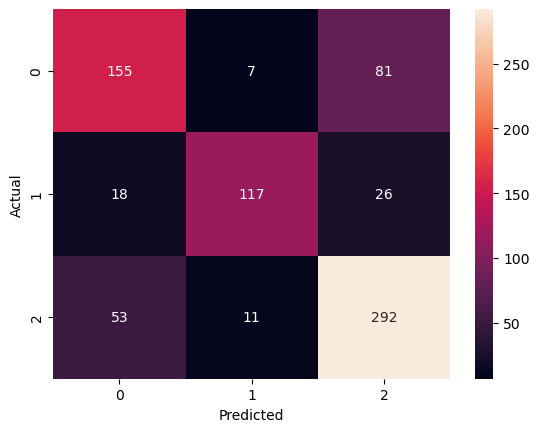

In [18]:
elo_model = ELO_Insights_model()
elo_model.fit(X_train, y_train)
y_pred = elo_model.predict(X_test)
print('Accuracy:', elo_model.score(y_pred, y_test))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
print(X.columns)


Index(['Home Team ELO', 'Away Team ELO', 'Home XG', 'Away XG', 'Home XGA',
       'Away XGA', 'Home Win Percentage', 'Home Draw Percentage',
       'Away Win Percentage', 'Away Draw Percentage', 'Home Team Form',
       'Away Team Form', 'Home Team Cumulative Points',
       'Away Team Cumulative Points'],
      dtype='object')


In [ ]:
from sklearn.decomposition import PCA

for components in [1,2,5,10]:
    pca = PCA(n_components=components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    elo_model.fit(X_train_pca, y_train)
    y_pred = elo_model.predict(X_test_pca)
    print(f'Accuracy with PCA {components}: {elo_model.score(y_pred, y_test)}')


In [53]:
from sklearn.feature_selection import RFE

for n_features in [1,2,5,10]:
    rfe = RFE(estimator=rf_model, n_features_to_select=n_features)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    elo_model.fit(X_train_rfe, y_train)
    y_pred = elo_model.predict(X_test_rfe)
    print(f'Accuracy with RFE {n_features}: {elo_model.score(y_pred, y_test)}')
    print(f'Selected features: {X.columns[rfe.support_]}')

Accuracy with RFE 1: 0.49078947368421055
Selected features: Index(['Away Team ELO'], dtype='object')
Accuracy with RFE 2: 0.6039473684210527
Selected features: Index(['Away Team ELO', 'Home XGA'], dtype='object')
Accuracy with RFE 5: 0.6934210526315789
Selected features: Index(['Home Team ELO', 'Away Team ELO', 'Away XG', 'Home XGA',
       'Away Win Percentage'],
      dtype='object')
Accuracy with RFE 10: 0.7171052631578947
Selected features: Index(['Home Team ELO', 'Away Team ELO', 'Home XG', 'Away XG', 'Home XGA',
       'Away XGA', 'Home Win Percentage', 'Home Draw Percentage',
       'Away Win Percentage', 'Away Draw Percentage'],
      dtype='object')


In [19]:
for season in ['2023-2024', '2022-2023']:
    data_ = pd.read_csv(f'Datasets/{season}_team_data.csv')
    data_['Team Form Statistics'] = np.nan
    for index, row in data_.iterrows():
        team = row['Team']
        team_form = team_statistics[(team_statistics['Team'] == team) & (team_statistics['Season'] == season)]['Rating'].values[0]
        data_.at[index, 'Team Form Statistics'] = team_form

    data_.to_csv(f'Datasets/{season}_team_data.csv', index=False)

In [14]:
team_data = pd.read_csv('Datasets/2024-2025_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
fixtures = pd.read_csv('Datasets/fixtures-2025.csv')
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points
0,Manchester Utd,878,57.0,73.0,60.55,21.94,0.333333,57
1,Leicester City,755,49.0,54.0,33.44,25.73,0.200000,31
2,Everton,789,30.0,60.0,35.78,27.81,0.666667,48
3,West Ham,785,36.0,75.0,33.61,25.23,0.266667,52
4,Tottenham,866,85.0,65.0,43.93,23.90,0.200000,63


In [15]:
elo_model = ELO_Insights_model()
elo_model.fit(X, y)

In [ ]:
for i, row in fixtures.iterrows():
    home_team = row['home']
    away_team = row['away']
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points  # Corresponds to 'Away Team Cumulative Points'

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)

    # predicted_result = elo_model.predict(entry_df)
    predicted_result = gb_model.predict(entry_df)

    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



In [17]:
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
print('Final Standings for 2024-2025')
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Tottenham: 74
Chelsea: 74
Arsenal: 72
Liverpool: 70
Manchester City: 70
Manchester Utd: 68
Newcastle Utd: 65
Aston Villa: 53
Crystal Palace: 53
Leicester City: 44
Fulham: 38
Nottingham Forest: 38
Everton: 33
West Ham: 33
Southampton: 31
Ipswich Town: 30
Brighton: 29
Wolves: 25
Bournemouth: 23
Brentford: 17


In [69]:
team_data = pd.read_csv('Datasets/2023-2024_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points,Team Form Statistics
0,West Ham,796,50.0,53.0,33.46,25.24,0.400000,37,61.57
1,Tottenham,868,60.0,60.0,43.69,24.16,0.266667,57,61.97
2,Arsenal,1002,81.0,35.0,54.16,24.39,0.400000,81,62.27
3,Crystal Palace,811,45.0,61.0,28.94,25.97,0.466667,44,61.64
4,Newcastle Utd,958,80.0,39.0,37.44,25.82,0.533333,70,62.05


In [70]:
fixtures_24 = dataset[dataset['Season'] == '2023-2024']

for i, row in fixtures_24.iterrows():
    home_team = row['Home Team']
    away_team = row['Away Team']
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]
    home_team_statistic = team_data[team_data['Team'] == home_team]['Team Form Statistics'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    away_team_statistic = team_data[team_data['Team'] == away_team]['Team Form Statistics'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points,  # Corresponds to 'Away Team Cumulative Points'
        home_team_statistic,         # Corresponds to 'Home Team Form Statistics'
        away_team_statistic          # Corresponds to 'Away Team Form Statistics

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)

    predicted_result = elo_model.predict(entry_df)

    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



Arsenal vs Nott'ham Forest: 1
Chelsea vs Liverpool: 0
Newcastle Utd vs Aston Villa: 1
Manchester Utd vs Wolves: 1
Brighton vs Luton Town: 0
Bournemouth vs West Ham: 0
Everton vs Fulham: 1
Brentford vs Tottenham: -1
Burnley vs Manchester City: 0
Sheffield Utd vs Crystal Palace: 1
Manchester City vs Newcastle Utd: 0
Liverpool vs Bournemouth: 1
Aston Villa vs Everton: 0
Tottenham vs Manchester Utd: 0
West Ham vs Chelsea: 0
Crystal Palace vs Arsenal: 0
Fulham vs Brentford: -1
Wolves vs Brighton: 0
Nott'ham Forest vs Sheffield Utd: 0
Luton Town vs Burnley: 0
Arsenal vs Fulham: 1
Chelsea vs Luton Town: 0
Newcastle Utd vs Liverpool: 0
Manchester Utd vs Nott'ham Forest: 1
Brighton vs West Ham: 1
Bournemouth vs Tottenham: -1
Everton vs Wolves: 1
Brentford vs Crystal Palace: 0
Burnley vs Aston Villa: -1
Sheffield Utd vs Manchester City: 0
Manchester City vs Fulham: 1
Arsenal vs Manchester Utd: 0
Liverpool vs Aston Villa: 1
Chelsea vs Nott'ham Forest: 0
Crystal Palace vs Wolves: 0
Brighton vs New

In [71]:
print('Final Standings for 2023-2024 season')
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Final Standings for 2023-2024 season
Manchester City: 74
Newcastle Utd: 68
Liverpool: 68
Aston Villa: 67
Manchester Utd: 65
Arsenal: 62
Tottenham: 60
Brighton: 56
Sheffield Utd: 55
Chelsea: 49
Burnley: 46
Everton: 46
West Ham: 33
Crystal Palace: 33
Luton Town: 30
Nott'ham Forest: 29
Wolves: 27
Brentford: 25
Fulham: 24
Bournemouth: 14


In [49]:
team_data = pd.read_csv('Datasets/2022-2023_team_data.csv')
final_standings = {team:0 for team in team_data['Team']}
team_data.head()

,Team,ELO,XG,XGA,Win Percentage,Draw Percentage,Team Form,Team Cumulative Points,Team Form Statistics
0,Leicester City,885,52.0,48.0,34.04,26.19,0.466667,49,61.68
1,Everton,797,47.0,59.0,36.32,27.83,0.666667,39,61.51
2,West Ham,875,46.0,49.0,33.67,25.35,0.333333,56,61.66
3,Tottenham,980,72.0,65.0,43.43,24.46,0.533333,62,62.29
4,Arsenal,966,65.0,45.0,53.69,24.67,0.600000,66,62.01


In [50]:
fixtures_23 = dataset[dataset['Season'] == '2022-2023']

for i, row in fixtures_23.iterrows():

    home_team = row['Home Team']
    away_team = row['Away Team']

    print(f'{home_team} vs {away_team}')
    home_ELO = team_data[team_data['Team'] == home_team]['ELO'].values[0]
    home_XG = team_data[team_data['Team'] == home_team]['XG'].values[0]
    home_XGA = team_data[team_data['Team'] == home_team]['XGA'].values[0]
    home_win_percentage = team_data[team_data['Team'] == home_team]['Win Percentage'].values[0]
    home_draw_percentage = team_data[team_data['Team'] == home_team]['Draw Percentage'].values[0]
    home_team_form = team_data[team_data['Team'] == home_team]['Team Form'].values[0]
    home_team_cumulative_points = team_data[team_data['Team'] == home_team]['Team Cumulative Points'].values[0]
    home_team_statistic = team_data[team_data['Team'] == home_team]['Team Form Statistics'].values[0]

    away_ELO = team_data[team_data['Team'] == away_team]['ELO'].values[0]
    away_XG = team_data[team_data['Team'] == away_team]['XG'].values[0]
    away_XGA = team_data[team_data['Team'] == away_team]['XGA'].values[0]
    away_win_percentage = team_data[team_data['Team'] == away_team]['Win Percentage'].values[0]
    away_draw_percentage = team_data[team_data['Team'] == away_team]['Draw Percentage'].values[0]
    away_team_form = team_data[team_data['Team'] == away_team]['Team Form'].values[0]
    away_team_cumulative_points = team_data[team_data['Team'] == away_team]['Team Cumulative Points'].values[0]
    away_team_statistic = team_data[team_data['Team'] == away_team]['Team Form Statistics'].values[0]
    
    entry = [
        home_ELO,                    # Corresponds to 'Home Team ELO'
        away_ELO,                    # Corresponds to 'Away Team ELO'
        home_XG,                     # Corresponds to 'Home Team XG'
        away_XG,                     # Corresponds to 'Away Team XG'
        home_XGA,                    # Corresponds to 'Home Team XGA'
        away_XGA,                    # Corresponds to 'Away Team XGA'
        home_win_percentage,         # Corresponds to 'Home Team Win Percentage'
        home_draw_percentage,        # Corresponds to 'Home Team Draw Percentage'
        away_win_percentage,         # Corresponds to 'Away Team Win Percentage'
        away_draw_percentage,        # Corresponds to 'Away Team Draw Percentage'
        home_team_form,              # Corresponds to 'Home Team Form'
        away_team_form,              # Corresponds to 'Away Team Form'
        home_team_cumulative_points, # Corresponds to 'Home Team Cumulative Points'
        away_team_cumulative_points,  # Corresponds to 'Away Team Cumulative Points'
        home_team_statistic,         # Corresponds to 'Home Team Form Statistics'
        away_team_statistic          # Corresponds to 'Away Team Form Statistics

    ]
    entry_df = pd.DataFrame([entry], columns=X_train.columns)

    predicted_result = elo_model.predict(entry_df)
    print(f'{home_team} vs {away_team}: {predicted_result[0]}')

    if predicted_result[0] == 1:
        final_standings[home_team] += 3

    elif predicted_result[0] == 0:
        final_standings[home_team] += 1
        final_standings[away_team] += 1

    elif predicted_result[0] == -1:
        final_standings[away_team] += 3



Crystal Palace vs Arsenal
Crystal Palace vs Arsenal: 1
Fulham vs Liverpool
Fulham vs Liverpool: 0
Tottenham vs Southampton
Tottenham vs Southampton: 1
Newcastle Utd vs Nott'ham Forest
Newcastle Utd vs Nott'ham Forest: 0
Leeds United vs Wolves
Leeds United vs Wolves: 0
Bournemouth vs Aston Villa
Bournemouth vs Aston Villa: 0
Everton vs Chelsea
Everton vs Chelsea: 0
Leicester City vs Brentford
Leicester City vs Brentford: 1
Manchester Utd vs Brighton
Manchester Utd vs Brighton: 1
West Ham vs Manchester City
West Ham vs Manchester City: 0
Aston Villa vs Everton
Aston Villa vs Everton: 0
Manchester City vs Bournemouth
Manchester City vs Bournemouth: 1
Southampton vs Leeds United
Southampton vs Leeds United: 0
Wolves vs Fulham
Wolves vs Fulham: 0
Arsenal vs Leicester City
Arsenal vs Leicester City: 1
Brighton vs Newcastle Utd
Brighton vs Newcastle Utd: 0
Brentford vs Manchester Utd
Brentford vs Manchester Utd: 1
Nott'ham Forest vs West Ham
Nott'ham Forest vs West Ham: 0
Chelsea vs Tottenham

In [51]:
print('Final Standings for 2022-2023 Season')
final_standings = dict(sorted(final_standings.items(), key=lambda item: item[1], reverse=True))
for team in final_standings:
    print(f'{team}: {final_standings[team]}')


Final Standings for 2022-2023 Season
Tottenham: 77
Arsenal: 68
Liverpool: 68
Manchester City: 68
Chelsea: 58
Brighton: 54
Leicester City: 52
Crystal Palace: 46
Fulham: 46
Newcastle Utd: 43
Leeds United: 42
Bournemouth: 41
Manchester Utd: 38
West Ham: 37
Wolves: 35
Everton: 34
Nott'ham Forest: 34
Aston Villa: 29
Southampton: 25
Brentford: 22


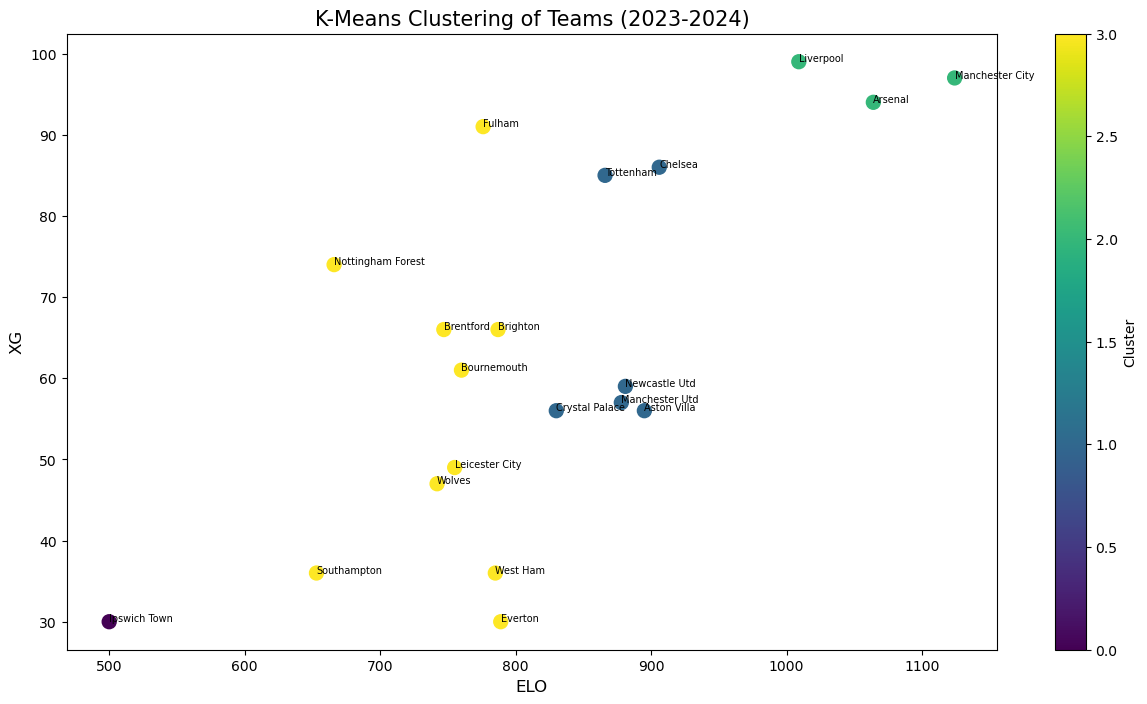

In [54]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
team_data_24_25 = pd.read_csv('Datasets/2024-2025_team_data.csv')


kmeans = KMeans(n_clusters=4).fit(team_data_24_25[['ELO', 'XG']])
team_data_24_25['Cluster'] = kmeans.labels_

plt.figure(figsize=(15, 8))
plt.scatter(team_data_24_25['ELO'], team_data_24_25['XG'], c=team_data_24_25['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_24_25.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=7)

# Labels and title
plt.title('K-Means Clustering of Teams (2023-2024)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()

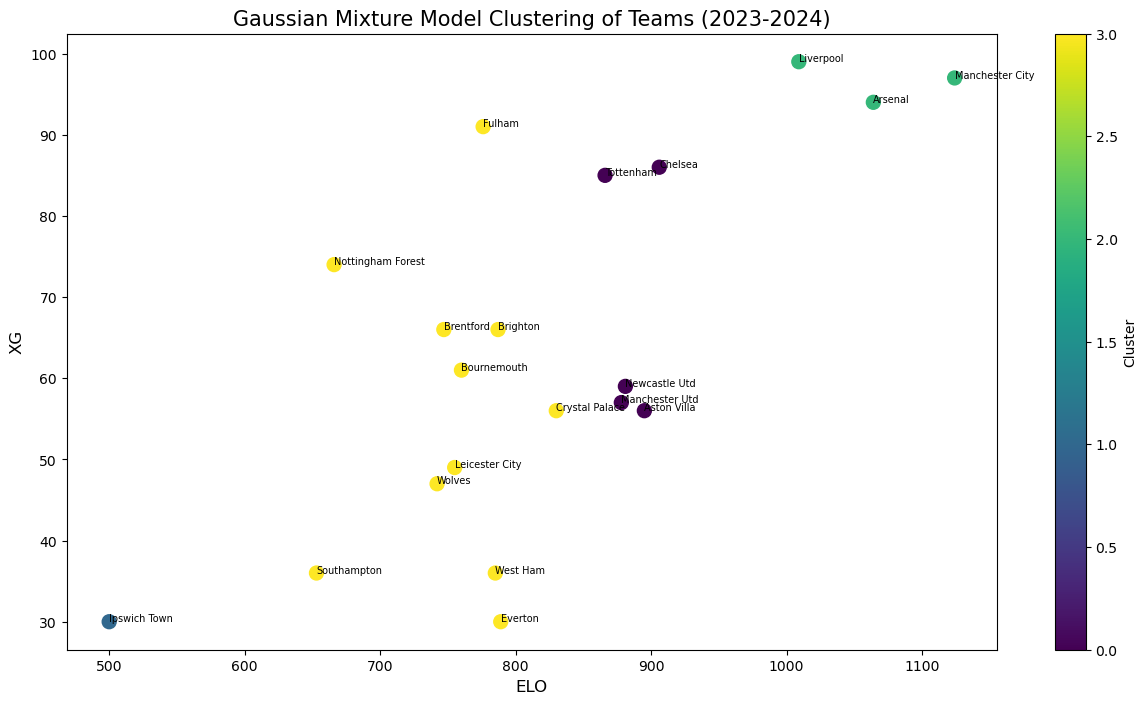

In [55]:
from sklearn.mixture import GaussianMixture

team_data_24_25 = pd.read_csv('Datasets/2024-2025_team_data.csv')

# Apply Gaussian Mixture Model (GMM) for clustering
gmm = GaussianMixture(n_components=4, random_state=42)
team_data_24_25['Cluster'] = gmm.fit_predict(team_data_24_25[['ELO', 'XG']])

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(team_data_24_25['ELO'], team_data_24_25['XG'], c=team_data_24_25['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_24_25.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=7)

# Labels and title
plt.title('Gaussian Mixture Model Clustering of Teams (2023-2024)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()

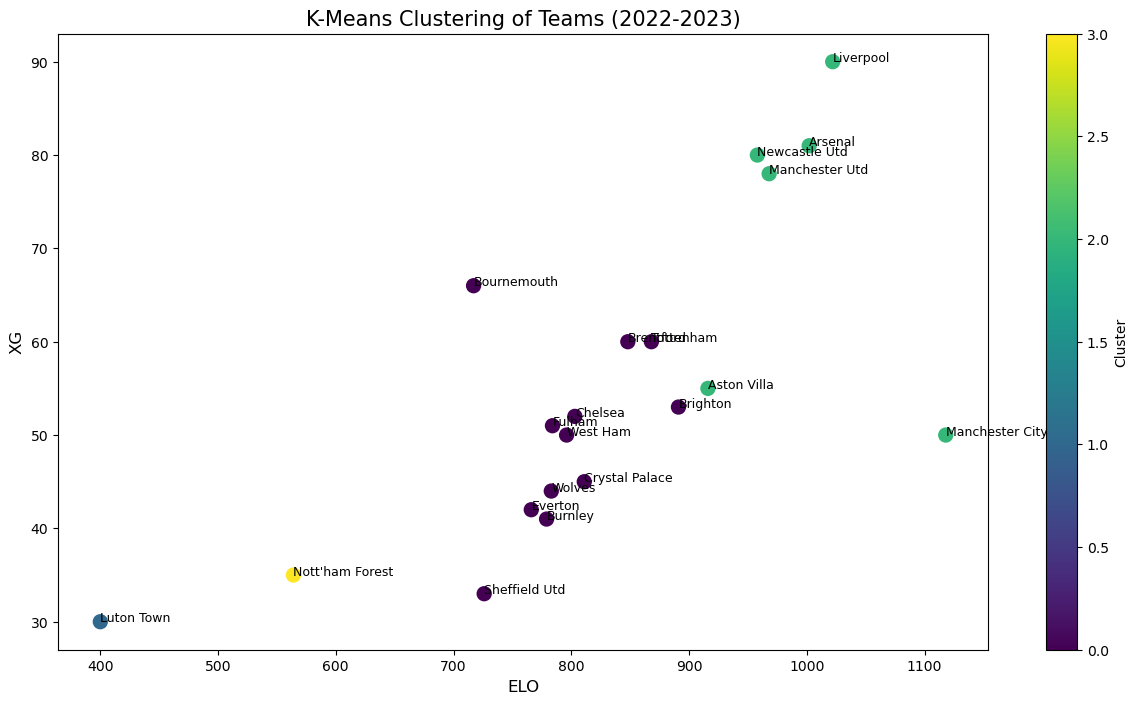

In [56]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
team_data_23_24 = pd.read_csv('Datasets/2023-2024_team_data.csv')


kmeans = KMeans(n_clusters=4).fit(team_data_23_24[['ELO', 'XG']])
team_data_23_24['Cluster'] = kmeans.labels_

plt.figure(figsize=(15, 8))
plt.scatter(team_data_23_24['ELO'], team_data_23_24['XG'], c=team_data_23_24['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_23_24.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=9)

# Labels and title
plt.title('K-Means Clustering of Teams (2022-2023)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()

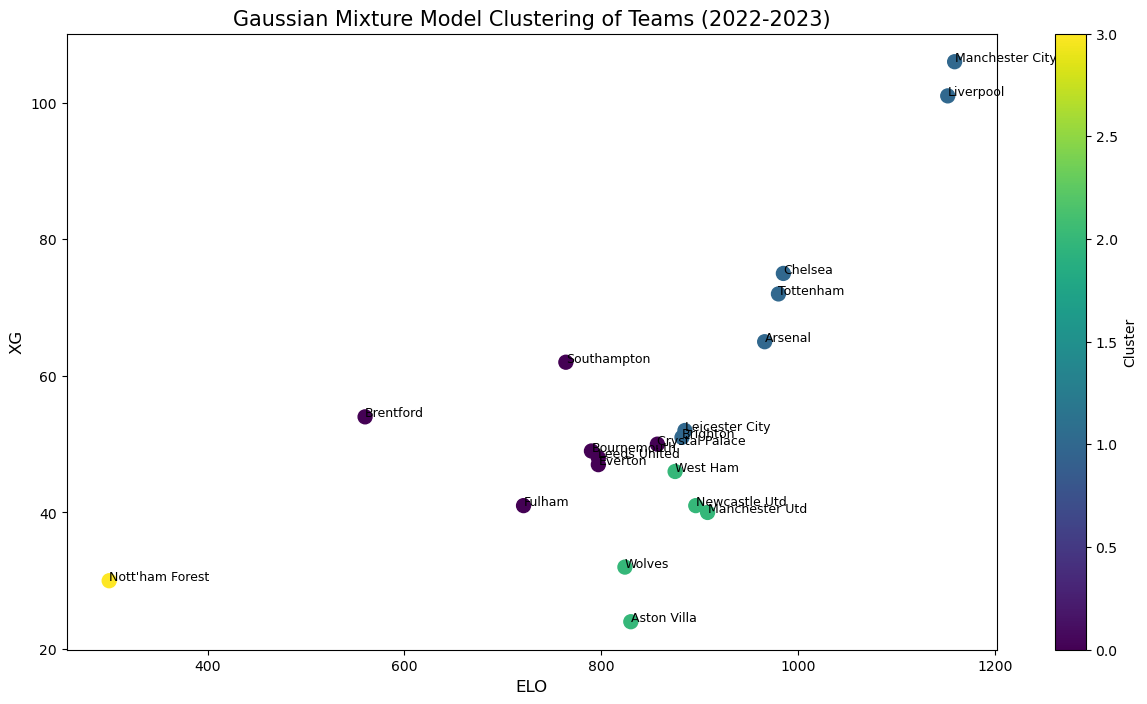

In [58]:
team_data_23_24 = pd.read_csv('Datasets/2023-2024_team_data.csv')

# Apply Gaussian Mixture Model (GMM) for clustering
gmm = GaussianMixture(n_components=4, random_state=42)
team_data_23_24['Cluster'] = gmm.fit_predict(team_data_23_24[['ELO', 'XG']])

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(team_data_23_24['ELO'], team_data_23_24['XG'], c=team_data_23_24['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_23_24.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=9)

# Labels and title
plt.title('Gaussian Mixture Model Clustering of Teams (2022-2023)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()

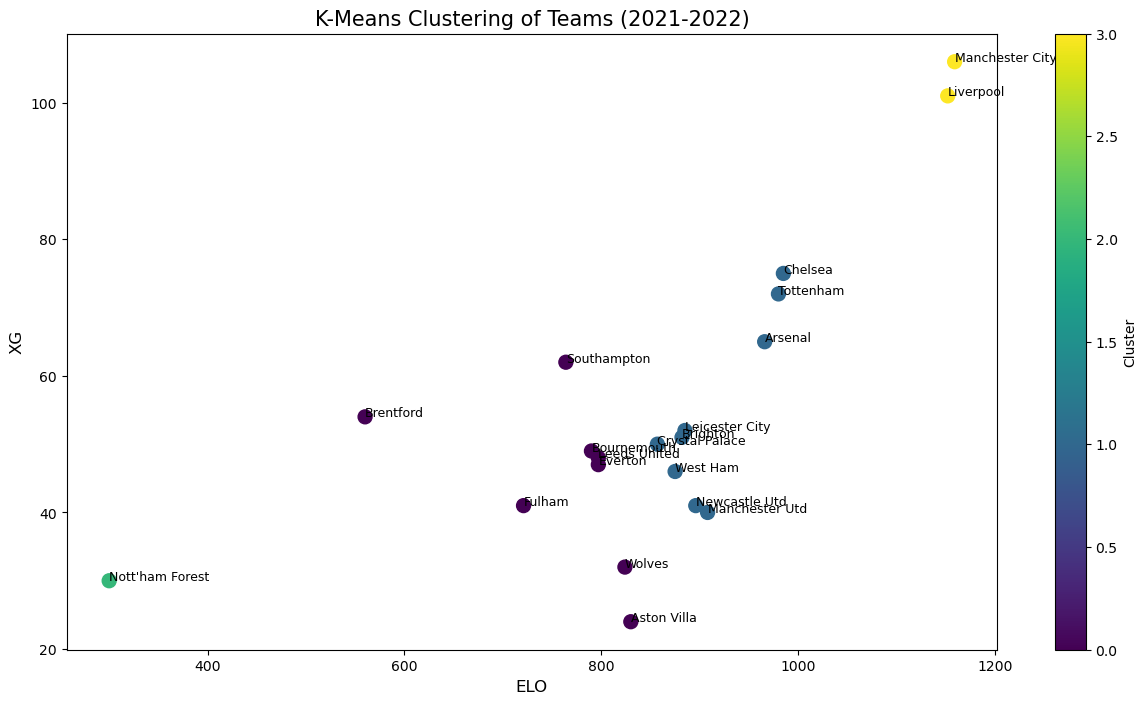

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
team_data_22_23 = pd.read_csv('Datasets/2022-2023_team_data.csv')


kmeans = KMeans(n_clusters=4).fit(team_data_22_23[['ELO', 'XG']])
team_data_22_23['Cluster'] = kmeans.labels_

plt.figure(figsize=(15, 8))
plt.scatter(team_data_22_23['ELO'], team_data_22_23['XG'], c=team_data_22_23['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_22_23.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=9)

# Labels and title
plt.title('K-Means Clustering of Teams (2021-2022)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()

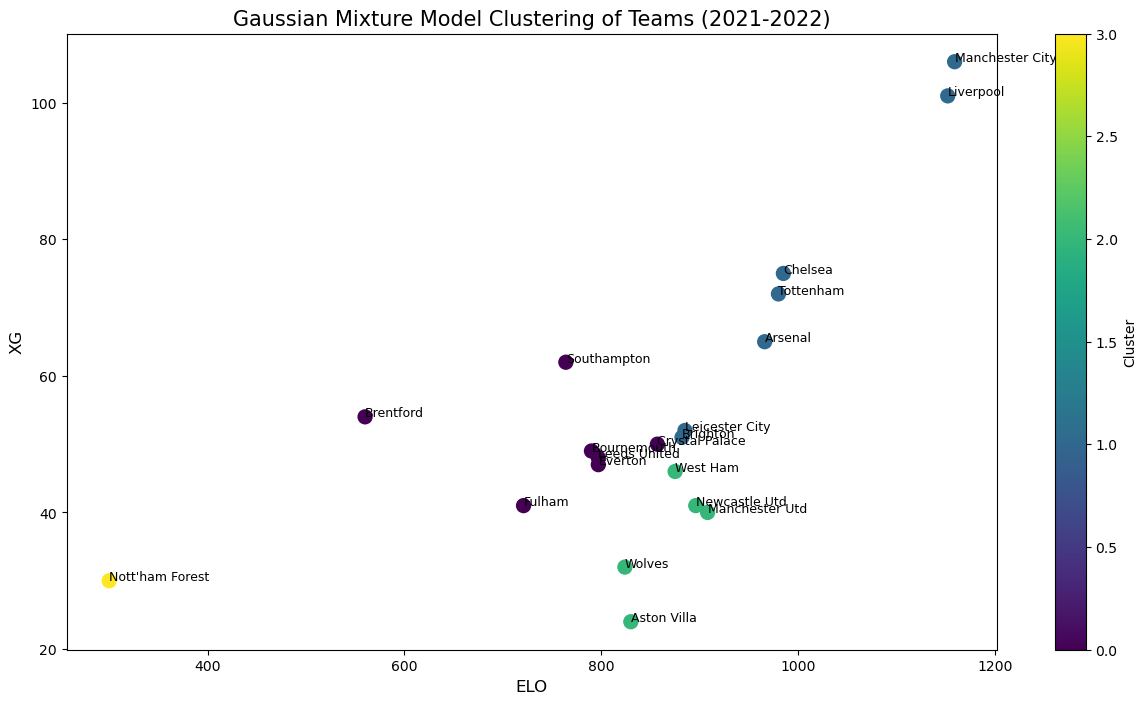

In [61]:
team_data_22_23 = pd.read_csv('Datasets/2022-2023_team_data.csv')

# Apply Gaussian Mixture Model (GMM) for clustering
gmm = GaussianMixture(n_components=4, random_state=42)
team_data_22_23['Cluster'] = gmm.fit_predict(team_data_22_23[['ELO', 'XG']])

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(team_data_22_23['ELO'], team_data_22_23['XG'], c=team_data_22_23['Cluster'], cmap='viridis', s=100)

# Annotating the teams with their names
for i, row in team_data_22_23.iterrows():
    plt.text(row['ELO'], row['XG'], row['Team'], fontsize=9)

# Labels and title
plt.title('Gaussian Mixture Model Clustering of Teams (2021-2022)', fontsize=15)
plt.xlabel('ELO', fontsize=12)
plt.ylabel('XG', fontsize=12)
plt.colorbar(label='Cluster')

plt.show()